In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import yfinance as yf

In [2]:
# getting our dataset
df =              yf.download('SNPS')
df =              df.reset_index()
df['tmrw_close'] =      df['Close'].shift(-1) 

# getting the last 2 years of data. counting leap day because why not man
numberToGetLastTwoYears = len(df) - 731
df =              df.iloc[len(df)-804 : len(df) - 73].copy()

# rearranging the columns becuase I was kind of annoyed by the way yfinance gives it to us lol
cols =            df.columns.tolist()
cols =            cols[4:5] + cols[:4]    + cols[5:]
df =              df[cols]

# dropping the date because we don't need it and i forgot to do it earlier
df = df.drop(['Date'], axis=1)

# since we shifted everything up one, the very last value for tmrw_close is NA. we need to fill that in
df['tmrw_close'] =      df['tmrw_close'].fillna(method='ffill', limit=2)
data = df
data

[*********************100%***********************]  1 of 1 completed


,Close,Open,High,Low,Adj Close,Volume,tmrw_close
7099,151.080002,148.899994,151.850006,147.979996,151.080002,913600,154.240005
7100,154.240005,151.880005,155.160004,151.610001,154.240005,693300,156.830002
7101,156.830002,155.009995,157.970001,154.589996,156.830002,660300,158.940002
7102,158.940002,158.000000,160.070007,157.279999,158.940002,827100,160.169998
7103,160.169998,160.419998,161.990005,158.690002,160.169998,723900,161.580002
...,...,...,...,...,...,...,...
7825,371.350006,373.390015,381.859985,371.170013,371.350006,723600,379.399994
7826,379.399994,375.470001,381.130005,371.230011,379.399994,974400,376.559998
7827,376.559998,378.140015,379.959991,370.369995,376.559998,944500,373.920013
7828,373.920013,377.089996,378.779999,371.200012,373.920013,655100,369.869995


In [3]:
data['y'] = data['Close']

x = data.iloc[:, :7].values
y = data.iloc[:, 7].values

split = int(data.shape[0]* 0.8)
train_x, test_x = x[: split, :], x[split:, :]
train_y, test_y = y[: split, ], y[split: , ]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')

x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))

train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

train_y = y_scaler.fit_transform(train_y.reshape(-1, 1))
test_y = y_scaler.transform(test_y.reshape(-1, 1))

trainX: (584, 7) trainY: (584,)
testX: (147, 7) testY: (147,)


In [4]:
class VAE(nn.Module):
    def __init__(self, config, latent_dim):
        super().__init__()

        modules = []
        for i in range(1, len(config)):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i - 1], config[i]),
                    nn.ReLU()
                )
            )
        
        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(config[-1], latent_dim)
        self.fc_var = nn.Linear(config[-1], latent_dim)

        modules = []
        self.decoder_input = nn.Linear(latent_dim, config[-1])

        for i in range(len(config) - 1, 1, -1):
            modules.append(
                nn.Sequential(
                    nn.Linear(config[i], config[i - 1]),
                    nn.ReLU()
                )
            )       
        modules.append(
            nn.Sequential(
                nn.Linear(config[1], config[0]),
                nn.Sigmoid()
            )
        ) 

        self.decoder = nn.Sequential(*modules)

    def encode(self, x):
        result = self.encoder(x)
        mu = self.fc_mu(result)
        logVar = self.fc_var(result)
        return mu, logVar

    def decode(self, x):
        result = self.decoder(x)
        return result

    def reparameterize(self, mu, logVar):
        std = torch.exp(0.5* logVar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x):
        mu, logVar = self.encode(x)
        z = self.reparameterize(mu, logVar)
        output = self.decode(z)
        return output, z, mu, logVar

In [5]:
train_loader = DataLoader(TensorDataset(torch.from_numpy(train_x).float()), batch_size = 128, shuffle = False)
model = VAE([7, 400, 400, 400, 10], 10)

[1/30] Loss: 122.54773139953613
[2/30] Loss: 122.07596206665039
[3/30] Loss: 117.46969604492188
[4/30] Loss: 115.38648700714111
[5/30] Loss: 119.02952671051025
[6/30] Loss: 117.15617275238037
[7/30] Loss: 110.69401454925537
[8/30] Loss: 106.10556507110596
[9/30] Loss: 104.91409397125244
[10/30] Loss: 102.93274784088135
[11/30] Loss: 97.30417919158936
[12/30] Loss: 92.82398509979248
[13/30] Loss: 91.39880180358887
[14/30] Loss: 91.10422992706299
[15/30] Loss: 90.00530052185059
[16/30] Loss: 87.66600894927979
[17/30] Loss: 84.51207160949707
[18/30] Loss: 80.97897148132324
[19/30] Loss: 76.90472507476807
[20/30] Loss: 72.3689489364624
[21/30] Loss: 67.84991645812988
[22/30] Loss: 65.04169464111328
[23/30] Loss: 66.0512580871582
[24/30] Loss: 67.85117053985596
[25/30] Loss: 64.36359977722168
[26/30] Loss: 57.79084777832031
[27/30] Loss: 53.30055046081543
[28/30] Loss: 52.06221532821655
[29/30] Loss: 52.30481195449829
[30/30] Loss: 52.384419441223145


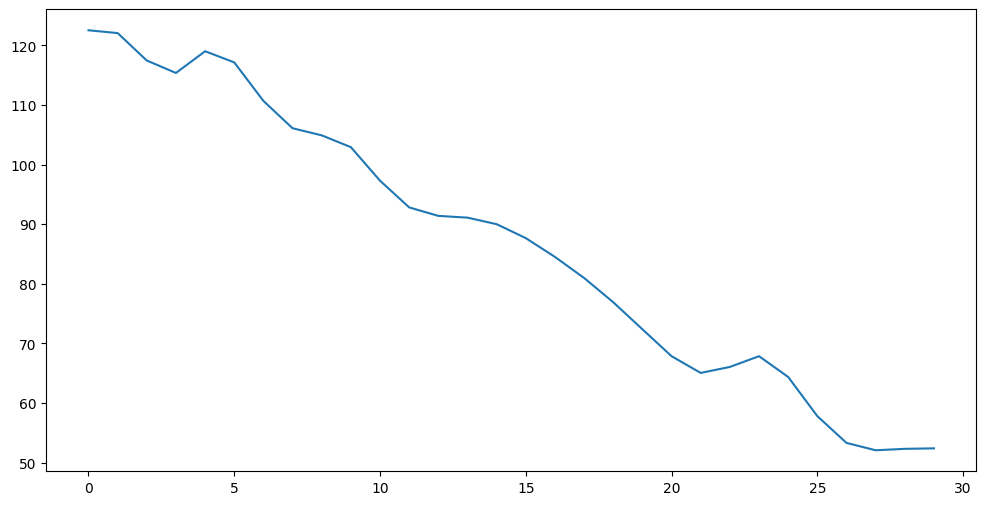

In [6]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
num_epochs = 30 #ORIGINALLY 300
learning_rate = 0.0003 #ORIGINALLY 0.00003
model = model.to(device)   
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

hist = np.zeros(num_epochs) 
for epoch in range(num_epochs):
    total_loss = 0
    loss_ = []
    for (x, ) in train_loader:
        x = x.to(device)
        output, z, mu, logVar = model(x)
        kl_divergence = 0.5* torch.sum(-1 - logVar + mu.pow(2) + logVar.exp())
        loss = F.binary_cross_entropy(output, x) + kl_divergence
        loss.backward()
        optimizer.step()
        loss_.append(loss.item())
    hist[epoch] = sum(loss_)
    print('[{}/{}] Loss:'.format(epoch+1, num_epochs), sum(loss_))

plt.figure(figsize=(12, 6))
plt.plot(hist)

In [7]:
model.eval()
_, VAE_train_x, train_x_mu, train_x_var = model(torch.from_numpy(train_x).float().to(device))
_, VAE_test_x, test_x_mu, test_x_var = model(torch.from_numpy(test_x).float().to(device))

In [8]:
def sliding_window(x, y, window):
    x_ = []
    y_ = []
    y_gan = []
    for i in range(window, x.shape[0]):
        tmp_x = x[i - window: i, :]
        tmp_y = y[i]
        tmp_y_gan = y[i - window: i + 1]
        x_.append(tmp_x)
        y_.append(tmp_y)
        y_gan.append(tmp_y_gan)
    x_ = torch.from_numpy(np.array(x_)).float()
    y_ = torch.from_numpy(np.array(y_)).float()
    y_gan = torch.from_numpy(np.array(y_gan)).float()
    return x_, y_, y_gan

In [9]:
train_x = np.concatenate((train_x, VAE_train_x.cpu().detach().numpy()), axis = 1)
test_x = np.concatenate((test_x, VAE_test_x.cpu().detach().numpy()), axis = 1)

In [10]:
train_x_slide, train_y_slide, train_y_gan = sliding_window(train_x, train_y, 3)
test_x_slide, test_y_slide, test_y_gan = sliding_window(test_x, test_y, 3)
print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape} train_y_gan: {train_y_gan.shape}')
print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape} test_y_gan: {test_y_gan.shape}')


train_x: torch.Size([581, 3, 17]) train_y: torch.Size([581, 1]) train_y_gan: torch.Size([581, 4, 1])
test_x: torch.Size([144, 3, 17]) test_y: torch.Size([144, 1]) test_y_gan: torch.Size([144, 4, 1])


In [11]:
class Generator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.gru_1 = nn.GRU(input_size, 1024, batch_first = True)
        self.gru_2 = nn.GRU(1024, 512, batch_first = True)
        self.gru_3 = nn.GRU(512, 256, batch_first = True)
        self.linear_1 = nn.Linear(256, 128)
        self.linear_2 = nn.Linear(128, 64)
        self.linear_3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        use_cuda = 1
        device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
        h0 = torch.zeros(1, x.size(0), 1024).to(device)
        out_1, _ = self.gru_1(x, h0)
        out_1 = self.dropout(out_1)
        h1 = torch.zeros(1, x.size(0), 512).to(device)
        out_2, _ = self.gru_2(out_1, h1)
        out_2 = self.dropout(out_2)
        h2 = torch.zeros(1, x.size(0), 256).to(device)
        out_3, _ = self.gru_3(out_2, h2)
        out_3 = self.dropout(out_3)
        out_4 = self.linear_1(out_3[:, -1, :])
        out_5 = self.linear_2(out_4)
        out = self.linear_3(out_5)
        return out

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(4, 32, kernel_size = 3, stride = 1, padding = 'same')
        self.conv2 = nn.Conv1d(32, 64, kernel_size = 3, stride = 1, padding = 'same')
        self.conv3 = nn.Conv1d(64, 128, kernel_size = 3, stride = 1, padding = 'same')
        self.linear1 = nn.Linear(128, 220)
        self.batch1 = nn.BatchNorm1d(220)
        self.linear2 = nn.Linear(220, 220)
        self.batch2 = nn.BatchNorm1d(220)
        self.linear3 = nn.Linear(220, 1)
        self.leaky = nn.LeakyReLU(0.01)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        conv1 = self.conv1(x)
        conv1 = self.leaky(conv1)
        conv2 = self.conv2(conv1)
        conv2 = self.leaky(conv2)
        conv3 = self.conv3(conv2)
        conv3 = self.leaky(conv3)
        flatten_x = conv3.reshape(conv3.shape[0], conv3.shape[1])
        out_1 = self.linear1(flatten_x)
        out_1 = self.leaky(out_1)
        out_2 = self.linear2(out_1)
        out_2 = self.relu(out_2)
        out_3 = self.linear3(out_2)
        out = self.sigmoid(out_3)
        return out

In [12]:
use_cuda = 1
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")

batch_size = 60
learning_rate = 0.00016
num_epochs = 30 #ORIGINALLY 165

trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_gan), batch_size = batch_size, shuffle = False)

modelG = Generator(17).to(device)
modelD = Discriminator().to(device)

criterion = nn.BCELoss()
optimizerG = torch.optim.Adam(modelG.parameters(), lr = learning_rate, betas = (0.0, 0.9))
optimizerD = torch.optim.Adam(modelD.parameters(), lr = learning_rate, betas = (0.0, 0.9))

histG = np.zeros(num_epochs)
histD = np.zeros(num_epochs)
count = 0
for epoch in range(num_epochs):
    loss_G = []
    loss_D = []
    for (x, y) in trainDataloader:
        x = x.to(device)
        y = y.to(device)

        fake_data = modelG(x)
        fake_data = torch.cat([y[:, :3, :], fake_data.reshape(-1, 1, 1)], axis = 1)

        dis_real_output = modelD(y)
        real_labels = torch.ones_like(dis_real_output).to(device)
        lossD_real = criterion(dis_real_output, real_labels)


        dis_fake_output = modelD(fake_data)
        fake_labels = torch.zeros_like(real_labels).to(device)
        lossD_fake = criterion(dis_fake_output, fake_labels)

        lossD = (lossD_real + lossD_fake)

        modelD.zero_grad()
        lossD.backward(retain_graph=True)
        optimizerD.step()
        loss_D.append(lossD.item())

        output_fake = modelD(fake_data)
        lossG = criterion(output_fake, real_labels)
        modelG.zero_grad()
        lossG.backward()
        optimizerG.step()
        loss_G.append(lossG.item()) 
    histG[epoch] = sum(loss_G) 
    histD[epoch] = sum(loss_D)    
    print(f'[{epoch+1}/{num_epochs}] LossD: {sum(loss_D)} LossG:{sum(loss_G)}')

[1/30] LossD: 13.860945701599121 LossG:6.850406050682068
[2/30] LossD: 13.866517663002014 LossG:6.914301216602325
[3/30] LossD: 13.862326264381409 LossG:6.9290823340415955
[4/30] LossD: 13.862313032150269 LossG:6.932246923446655
[5/30] LossD: 13.862758040428162 LossG:6.932081520557404
[6/30] LossD: 13.862622380256653 LossG:6.932190775871277
[7/30] LossD: 13.86263394355774 LossG:6.931981146335602
[8/30] LossD: 13.862852454185486 LossG:6.931901454925537
[9/30] LossD: 13.862853765487671 LossG:6.931832194328308
[10/30] LossD: 13.862847208976746 LossG:6.93140709400177
[11/30] LossD: 13.862879395484924 LossG:6.93201756477356
[12/30] LossD: 13.862897157669067 LossG:6.931172788143158
[13/30] LossD: 13.862822771072388 LossG:6.932001888751984
[14/30] LossD: 13.86282467842102 LossG:6.932044208049774
[15/30] LossD: 13.8626868724823 LossG:6.932522475719452
[16/30] LossD: 13.862827181816101 LossG:6.931300640106201
[17/30] LossD: 13.862694382667542 LossG:6.932287752628326
[18/30] LossD: 13.8624495267

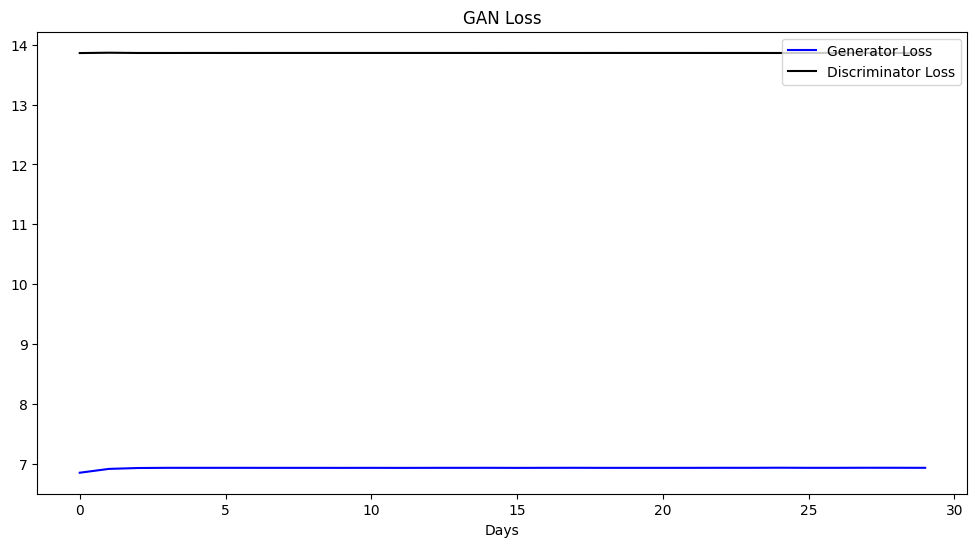

In [13]:
plt.figure(figsize = (12, 6))
plt.plot(histG, color = 'blue', label = 'Generator Loss')
plt.plot(histD, color = 'black', label = 'Discriminator Loss')
plt.title('GAN Loss')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

In [14]:
modelG.eval()
pred_y_train = modelG(train_x_slide.to(device))
pred_y_test = modelG(test_x_slide.to(device))

y_train_true = y_scaler.inverse_transform(train_y_slide)
y_train_pred = y_scaler.inverse_transform(pred_y_train.cpu().detach().numpy())
print(y_train_pred)
y_test_true = y_scaler.inverse_transform(test_y_slide)
y_test_pred = y_scaler.inverse_transform(pred_y_test.cpu().detach().numpy())

[[162.5445 ]
 [160.51242]
 [157.74493]
 [158.27843]
 [160.87003]
 [161.80089]
 [164.13147]
 [160.32356]
 [163.94522]
 [171.4813 ]
 [175.84686]
 [168.31691]
 [160.3013 ]
 [165.986  ]
 [176.44641]
 [176.58624]
 [171.82265]
 [181.02754]
 [187.41187]
 [181.41844]
 [175.77115]
 [180.61543]
 [185.53683]
 [192.60916]
 [193.52762]
 [199.99158]
 [192.51202]
 [193.1631 ]
 [189.37672]
 [193.47244]
 [194.77644]
 [194.90628]
 [191.3184 ]
 [189.50887]
 [194.52525]
 [195.40967]
 [194.43398]
 [191.32648]
 [197.44084]
 [197.38461]
 [202.44164]
 [202.25449]
 [205.2798 ]
 [208.67317]
 [209.1874 ]
 [205.06738]
 [204.21378]
 [199.93625]
 [195.18123]
 [202.58032]
 [206.85278]
 [207.72678]
 [206.95404]
 [212.19258]
 [212.90344]
 [214.94089]
 [204.04068]
 [203.83429]
 [199.98738]
 [201.25975]
 [203.07716]
 [206.53894]
 [202.99425]
 [210.38269]
 [209.76402]
 [212.02052]
 [208.55785]
 [200.4911 ]
 [201.5269 ]
 [201.57965]
 [197.68732]
 [204.49077]
 [208.66742]
 [207.80972]
 [208.60635]
 [210.6913 ]
 [213.17506]

Training dataset RMSE:17.188653127344036


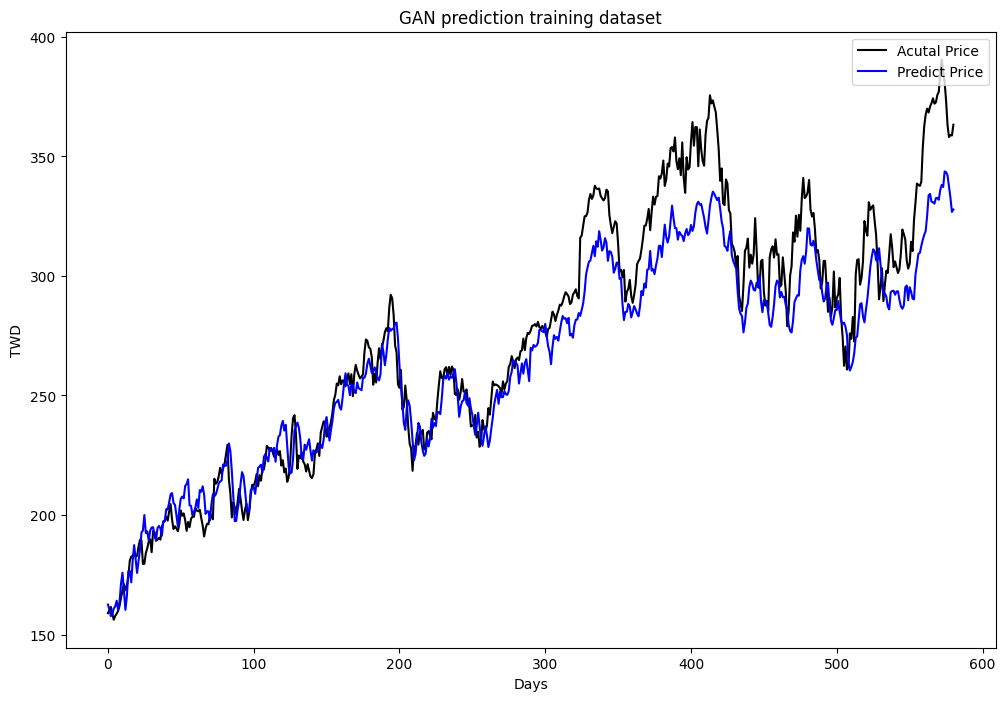

In [15]:
plt.figure(figsize=(12, 8))
plt.plot(y_train_true, color = 'black', label = 'Actual Price')
plt.plot(y_train_pred, color = 'blue', label = 'Predict Price')
plt.title('GAN prediction training dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Training dataset RMSE:26.523172931297278


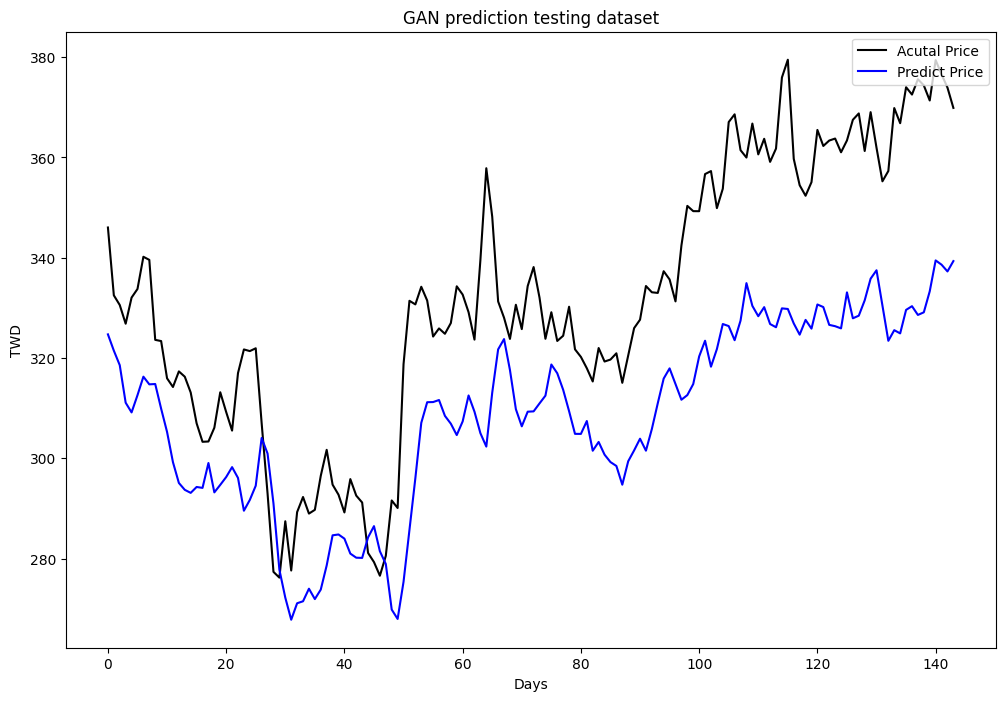

In [16]:
plt.figure(figsize=(12, 8))
plt.plot(y_test_true, color = 'black', label = 'Actual Price')
plt.plot(y_test_pred, color = 'blue', label = 'Predict Price')
plt.title('GAN prediction testing dataset')
plt.ylabel('TWD')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')